# Reflections on SXSW

A review of Apple's marketing and branding strategies at this year's South by Southwest Conference, to help the Apple marketing team plan next year's South by Southwest campaign.

## 0. Goals of the Analysis

To provide an overview of the brand's perception at this year's conference: what did people like, dislike and discuss the most? How was Apple perceived relative to its competitors?

- Build a classifier to "score" tweets as most negative, most positive and most neutral
- Determine the most negative and most positive SXSW tweets concerning Apple and its products
- Summarize the topics discussed in negative, neutral and positive tweets regarding Apple & its products


Ultimately, we hope to provide concrete recommendations for next year's SXSW brand & marketing strategy based on what was successful this year.

## Environment Set Up

Install xgboost and gensim, and download stopwords from nltk.

In [29]:
%pip install xgboost

%pip install gensim

import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Make a list of package versions used in this environment.

In [33]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

import xgboost
print(f'xgboost=={xgboost.__version__}')

import gensim
print(f'gensim=={gensim.__version__}')

sklearn==1.2.2
nltk==3.8.1
pandas==2.0.1
numpy==1.22.3
seaborn==0.12.2
xgboost==1.7.5
gensim==4.3.1
xgboost==1.7.5
gensim==4.3.1


Set a seed for random state.

In [17]:
seed = 8945593

Import specific packages needed from various libraries.

In [49]:
# general preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# text-specific preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# analysis
from nltk.probability import FreqDist

## 1. Data Understanding
### 1.1 Part 1

[Data Source](https://data.world/crowdflower/brands-and-product-emotions)

The data was downloaded from the above link on April 21, 2023 and has been stored in .csv format in the below referenced S3 bucket.

In [6]:
# load data

read_bucket = "twitter-sxsw"
file_name = "judge-1377884607_tweet_product_company.csv"

data_uri = f"s3://{read_bucket}/{file_name}"
data = pd.read_csv(data_uri, encoding='latin-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The "emotion_in_tweet_is_directed_at" category indicates the specific product at which the sentiment in the tweet is directed, if possible. For ease of analysis, we will add a column titled "brand" which simply indicates whether the object of the sentiment is "Apple", "Google", "Android" (or None), so that we can explore the distribution of tweet sentiment by brand.

We'll also rename the columns so that actions require less typing.

In [7]:
# change column names for ease of use
data.rename({'emotion_in_tweet_is_directed_at': 'object',
             'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, axis=1, inplace=True)

# add column (brand)
apple_categories = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone',
                    'Other Apple product or service']

android_categories = ['Android App', 'Android']

google_categories = ['Google', 'Other Google product or service']

brand_names = dict(zip(apple_categories, ['Apple']*len(apple_categories)))
brand_names.update(dict(zip(android_categories, ['Android']*len(android_categories))))
brand_names.update(dict(zip(google_categories, ['Google']*len(google_categories))))

data['brand'] = data.object.replace(brand_names)

data.head()

,tweet_text,object,sentiment,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google


#### Summary

- How many tweets are in the dataset overall?

&nbsp;

<center><b>9093 tweets</b></center>

- What is the distribution of the sentiment category?

| Sentiment | % of Data |
| --- | --- |
| Neutral | 59% |
| Positive | 33% |
| Negative | 6% |
| Null | 2% |

- How many null values are we dealing with for the object of the sentiment?

<center><b>357 tweets</b> are labeled as having a positive or negative emotion, but do not indicate the object of the sentiment in the tweet.</center>

&nbsp;

- Out of tweets for which the object of the sentiment is labeled, how many have sentiment directed toward ...

    - Apple? &nbsp;&nbsp; **2337 positive and negative tweets**
    - Google? &nbsp;&nbsp; **697 positive and negative tweets**
    - Android? &nbsp;&nbsp; **157 positive and negative tweets**
    
&nbsp;

- What is the distribution of sentiment for each brand?

<center><u>Apple and Google</u></center>
<center>~17% negative and ~83% positive</center>

&nbsp;

<center><u>Android</u></center>
<center>~10% negative and ~90% positive</center>

- What is the average length of a tweet in this dataset (in words)?

<center>The mean length of a tweet in this dataset is <b>18 words</b>. The shortest tweet contains only 2 words; the longest tweet contains 33 words.</center>

**Visualizations**

Below, graphs are generated to show the count of positive and negative tweets directed toward each brand.

Tweets with "no emotion" or ambiguous emotion ("I can't tell") are not included as most neutral tweets do not specify a brand.

In [47]:
sentiment_counts_by_brand = data.loc[~data.object.isna()].groupby(['brand', 'sentiment'])['tweet_text'].count()

Set style of plots to use throughout notebook.

*Note: The style is meant to emulate the color palette of the first graphic on the home page of the Apple website, as of June 7, 2023, which is introducing the Apple Vision Pro.*

In [8]:
plt.style.use("dark_background")
sns.set_palette('hsv')

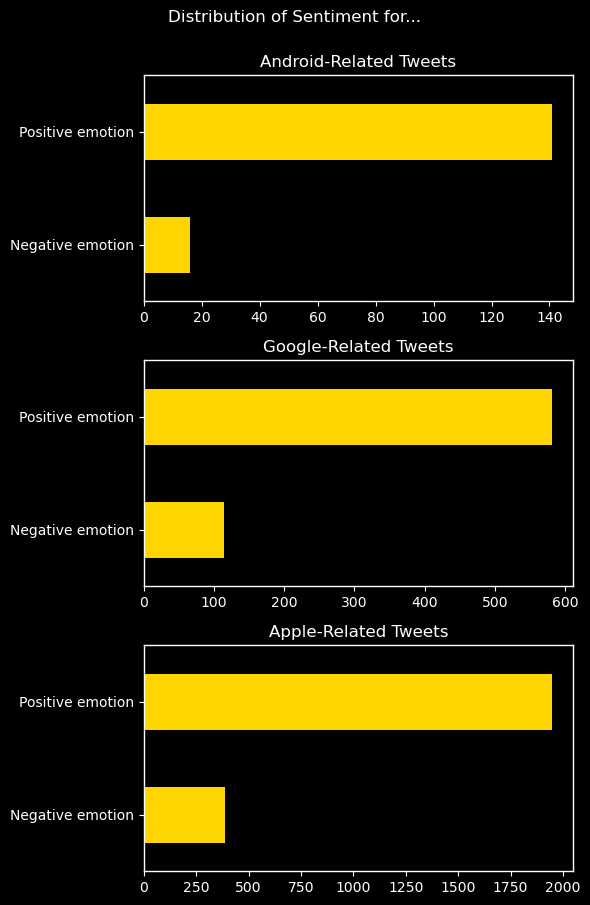

In [164]:
fig, ax = plt.subplots(nrows=3, figsize=(6, 9))

# Android plot
sentiment_counts_by_brand.loc[('Android',)].drop(
    ['No emotion toward brand or product'], axis=0
).plot(kind='barh', ax=ax[0])
ax[0].set_title('Android-Related Tweets')

# Google plot
sentiment_counts_by_brand.loc[('Google',)].drop(
    ['No emotion toward brand or product', "I can't tell"], axis=0
).plot(kind='barh', ax=ax[1])
ax[1].set_title('Google-Related Tweets')

# Apple plot
sentiment_counts_by_brand.loc[('Apple',)].drop(
    ['No emotion toward brand or product', "I can't tell"], axis=0
).plot(kind='barh', ax=ax[2])
ax[2].set_title('Apple-Related Tweets')

# don't label y-axis
for axis in ax:
    axis.set_ylabel('')
    
# avoid overlap of subplots
fig.suptitle('Distribution of Sentiment for...', y=1)
fig.tight_layout();

In [172]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [173]:
!git log --oneline

6642ec2 (HEAD -> main, origin/main, origin/HEAD) set up notebook environment and summarize data
687bb47 Broaden hyperparameter search with Amazon SageMaker notebook
ad863bc Refactor preprocessing code
900c8c7 Tune several model candidates
943cccf Reorganize preprocessing steps
9ff1241 More EDA
ab23639 Add eda step / brand breakdown
68b4479 Build a neural network; test different architectures
e76e83f Track negative recall score
87dbcf6 Make negative recall scorer
e00e38f Build stacked embedding
7ce8a6e Build custom word2vec model; try bag of words
f641e82 Plot confusion matrix; tune logistic regression; try random forest
4041f75 Test padding mean word vector
62aefa0 Preprocess data & set up for model tuning
0dc62d4 Ignore data
6e356bf Initial commit


## 2. Data Preparation
### 2.1 Part 1

Deal with null values.

In [10]:
# deal with null values
data.loc[data.tweet_text==None]

,tweet_text,object,sentiment,brand


In [13]:
data.dropna(subset=['tweet_text'], axis=0, inplace=True)

Split the data into train, validation and test sets.

In [23]:
X = data['tweet_text'].copy()
y = data['sentiment'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=0.25)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5454,)
(1819,)
(1819,)


Label encode the target.

In [26]:
# label encoding
le = LabelEncoder()

y_train_encoded = pd.Series(le.fit_transform(y_train), index=y_train.index)

y_val_encoded = pd.Series(le.transform(y_val), index=y_val.index)
y_test_encoded = pd.Series(le.transform(y_test), index=y_test.index)

Remove stop words, strip punctuation, and stem or lemmatize tokens.

In [45]:
# remove stop words, strip punctuation, and stem or lemmatize tokens
stopwords_list = stopwords.words('english')
stopwords_list.extend(['rt', 'sxsw', 'mention', 'quot;s&quot', 'quot;x&quot', 'quot;w&quot'])

porter = PorterStemmer()

X_train_stemmed = X_train.map(lambda x: [porter.stem(w.lower().strip(string.punctuation)) for w in x.split() if\
                                         w.lower().strip(string.punctuation) not in stopwords_list])
X_train_stemmed.head()

5711    [fals, alarm, googl, circl, come, probabl, eve...
8483    [notic, dst, come, weekend, mani, iphon, user,...
7760    [said, abl, get, ipad, 2, appl, open, pop-up, ...
6315     [might, need, go, appl, today, think, key, worn]
3258           [get, readi, listen, parti, podcast, link]
Name: tweet_text, dtype: object

In [47]:
X_val_stemmed = X_val.map(lambda x: [porter.stem(w.lower().strip(string.punctuation)) for w in x.split() if\
                                     w.lower().strip(string.punctuation) not in stopwords_list])
X_test_stemmed = X_test.map(lambda x: [porter.stem(w.lower().strip(string.punctuation)) for w in x.split() if\
                                       w.lower().strip(string.punctuation) not in stopwords_list])

## 1. Data Understanding
### 1.2 Part 2

Now that we have tokenized each tweet, we can build a frequency distribution for each sentiment category, for each brand. (It's possible that doing so will reveal additional stop words that ought to be removed, or some other pattern that can be captured in the data.)

To analyze the word distribution for each value of the target, we need a set of all training data with the labels included.

In [89]:
all_train = pd.concat([X_train_stemmed.map(lambda x: ' '.join(x)), y_train], axis=1)
all_train.head()

,tweet_text,sentiment
5711,fals alarm googl circl come probabl ever link ...,Negative emotion
8483,notic dst come weekend mani iphon user hour la...,Negative emotion
7760,said abl get ipad 2 appl open pop-up store aus...,No emotion toward brand or product
6315,might need go appl today think key worn,No emotion toward brand or product
3258,get readi listen parti podcast link,No emotion toward brand or product


Write a function to build a frequency distribution of the most common *n* words and display the results as a bar graph.

In [105]:
def display_fdist(data, n, normalize=False):
    '''Displays a bar graph representing the top n words in the data.'''
    fdist = FreqDist(' '.join(data.tolist()).split())
    top_n = {x[0]: x[1] for x in fdist.most_common(n)}
    raw = pd.Series(top_n)
    normalized = pd.Series(dict(zip(top_n.keys(), [x/fdist.N() for x in top_n.values()])))
    
    if normalize:
        graph_data = normalized
    else:
        graph_data = raw
    
    fig, ax = plt.subplots(figsize=(4, 4))
    
    sns.barplot(x=graph_data.values, y=graph_data.index);

Examine the most frequently occurring stems across the entire training data.

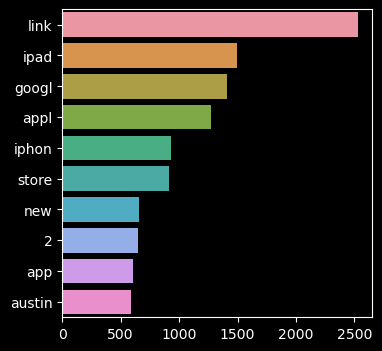

In [106]:
display_fdist(all_train.tweet_text, 10)

Normalizing the frequency distribution above suggests that, for modeling purposes, excluding words which occur more than 1% of the time would eliminate the top 10 words, and excluding words which occur more than 5% of the time would not eliminate any of the vocabulary.

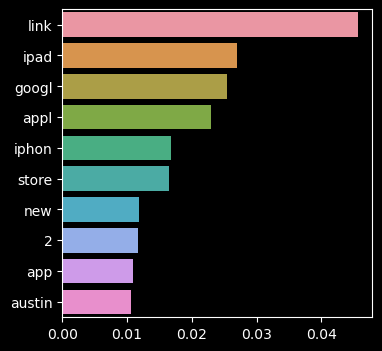

In [107]:
display_fdist(all_train.tweet_text, 10, normalize=True)

Examine the top 20 words in the frequency distribution for negative tweets.

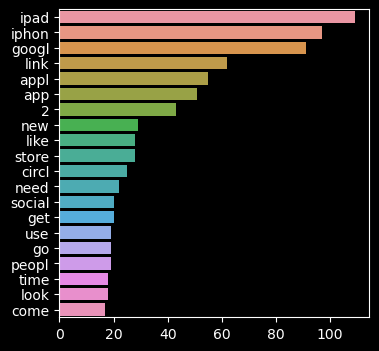

In [112]:
display_fdist(all_train.loc[all_train.sentiment=='Negative emotion', 'tweet_text'], 20)

Examine the top 20 words in the frequency distribution for positive tweets.

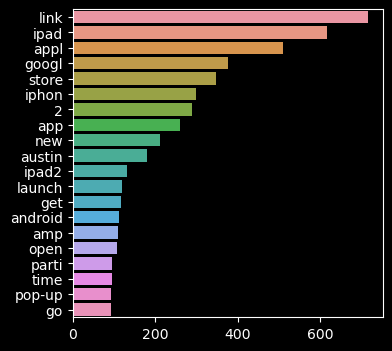

In [113]:
display_fdist(all_train.loc[all_train.sentiment=='Positive emotion', 'tweet_text'], 20)

Build a frequency distribution that includes bigrams (and possible trigrams.)

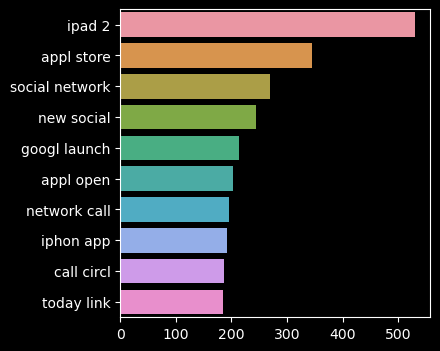

In [121]:
# build a frequency distribution that includes bigrams and possibly trigrams
top10 = FreqDist(nltk.bigrams(' '.join(all_train.tweet_text.tolist()).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index);

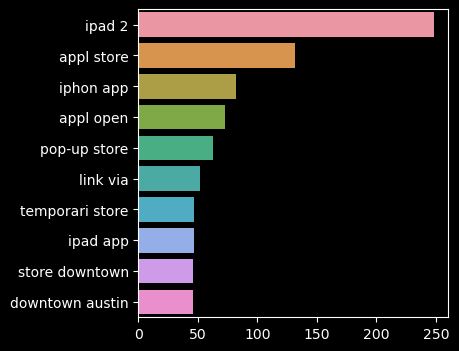

In [123]:
# build a frequency distribution for bigrams in POSITIVE tweets
top10 = FreqDist(nltk.bigrams(' '.join(
    all_train.loc[all_train.sentiment=='Positive emotion', 'tweet_text'].tolist()
).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index);

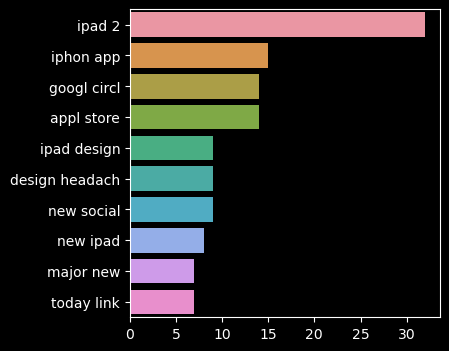

In [124]:
# build a frequency distribution for bigrams in NEGATIVE tweets
top10 = FreqDist(nltk.bigrams(' '.join(
    all_train.loc[all_train.sentiment=='Negative emotion', 'tweet_text'].tolist()
).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index);

## 2. Data Preparation
### 2.2 Part 2

Adjust stop words removed and lemmatization if needed.

## 3. Modeling
### 3.1 Selecting a Vectorizer and Optimizing Hyperparameters for Each Classification Algorithm

Use pipelines to test different vectorization techniques with different classification algorithms.

<u>Vectorizers</u>
- Count vectorization: ngram range, min / max df, max vocab
- "One hot" vectorization
- Tfidf vectorization: same as count vectorizer settings
- Mean word embeddings (using gensim's pretrained word2vec model)

<u>Classifiers</u>
- Decision Tree
- Nearest Neighbors
- Support Vector Classifier
- Naive Bayes
- Random Forest
- XGBoost (other library)

Use grid search and cross validation to find the optimal vectorization and hyperparameter settings for each classification algorithm.

## 4. Evaluation
### 4.1 Analyze Model Performance on Validation Set

In this section, the best model(s) so far are evaluated on the validation set after being trained on the training set. Insights from the model's performance on the validation set may be used to adjust preprocessing techniques and model hyperparameters.

Train the best model(s) on the training set, and analyze the performance of each model on the validation set using:

- overall accuracy (visualize: raw numbers confusion matrix)

- recall for each class (visualize: confusion matrix with normalize='true')

- both of the above for Apple-related tweets specifically (and perhaps each brand)

- grade_model_confidence function (displays bar chart with mean model accuracy as a function of model confidence in predicted class)

- use LIME to investigate most negative & positive tweets, or "most confident" mistakes (incorrect predictions for which the model was most confident)

- examine feature importances for the model

## 3. Modeling
### 3.2 Adjust Preprocessing Techniques and Model Hyperparameters

Based on evaluation of candidate models on the validation set, consider tweaking preprocessing techniques (esp. vectorization) and model hyperparameters.

## 4. Evaluation
### 4.2 Final Model Evaluation on Hold-out Test Set

In this section, the single best model is evaluated on the hold-out test set to approximate model performance on unseen data. Model analytics are used to determine whether the model is worthy for deployment.

Evaluate the best model's performance on the hold-out test set.

Analyze model mistakes, grade model confidence & find most positive and negative tweets about Apple specifically.

## 5. Modeling
### 5.1 Topic Modeling for Each Brand and Sentiment Category (using LDA)

If time permits, latent dirichlet allocation is used to perform topic modeling for each brand / sentiment category combination in the dataset.

The goal is to generate a visualization to allow the Apple marketing team to quickly understand which "topics" related to Apple and its competitors were viewed positively or negatively (or received the most attention) during South by Southwest this year.

Determine the optimal number of topics for each sentiment category for Apple:

Determine the topics and their weights via clustering:

Visualize the topics:

## 6. Evaluation
### 6.1 Evaluate Topic Models

Compute the perplexity and coherence score for the best model.

## 7. Recommendations
### 7.1 Recommendations for Apple's Next SXSW Campaign

Based on confidence scores generated by classifier:

Based on topic modeling for each brand / sentiment combination:

## 8. Conclusion

<u>Possible Next Steps</u>

-
-

<u>Further Reading</u>

A summary of the results from this analysis can be found in [this presentation]().

Learn more about South by Southwest [here](https://www.sxsw.com/).